<a href="https://colab.research.google.com/github/Carterbouley/ElectricityPricePrediction/blob/master/multivariate_LSTM_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [3]:
import pandas as pd
df = pd.read_csv('data_process_result/re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])

df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)
df=df.dropna()

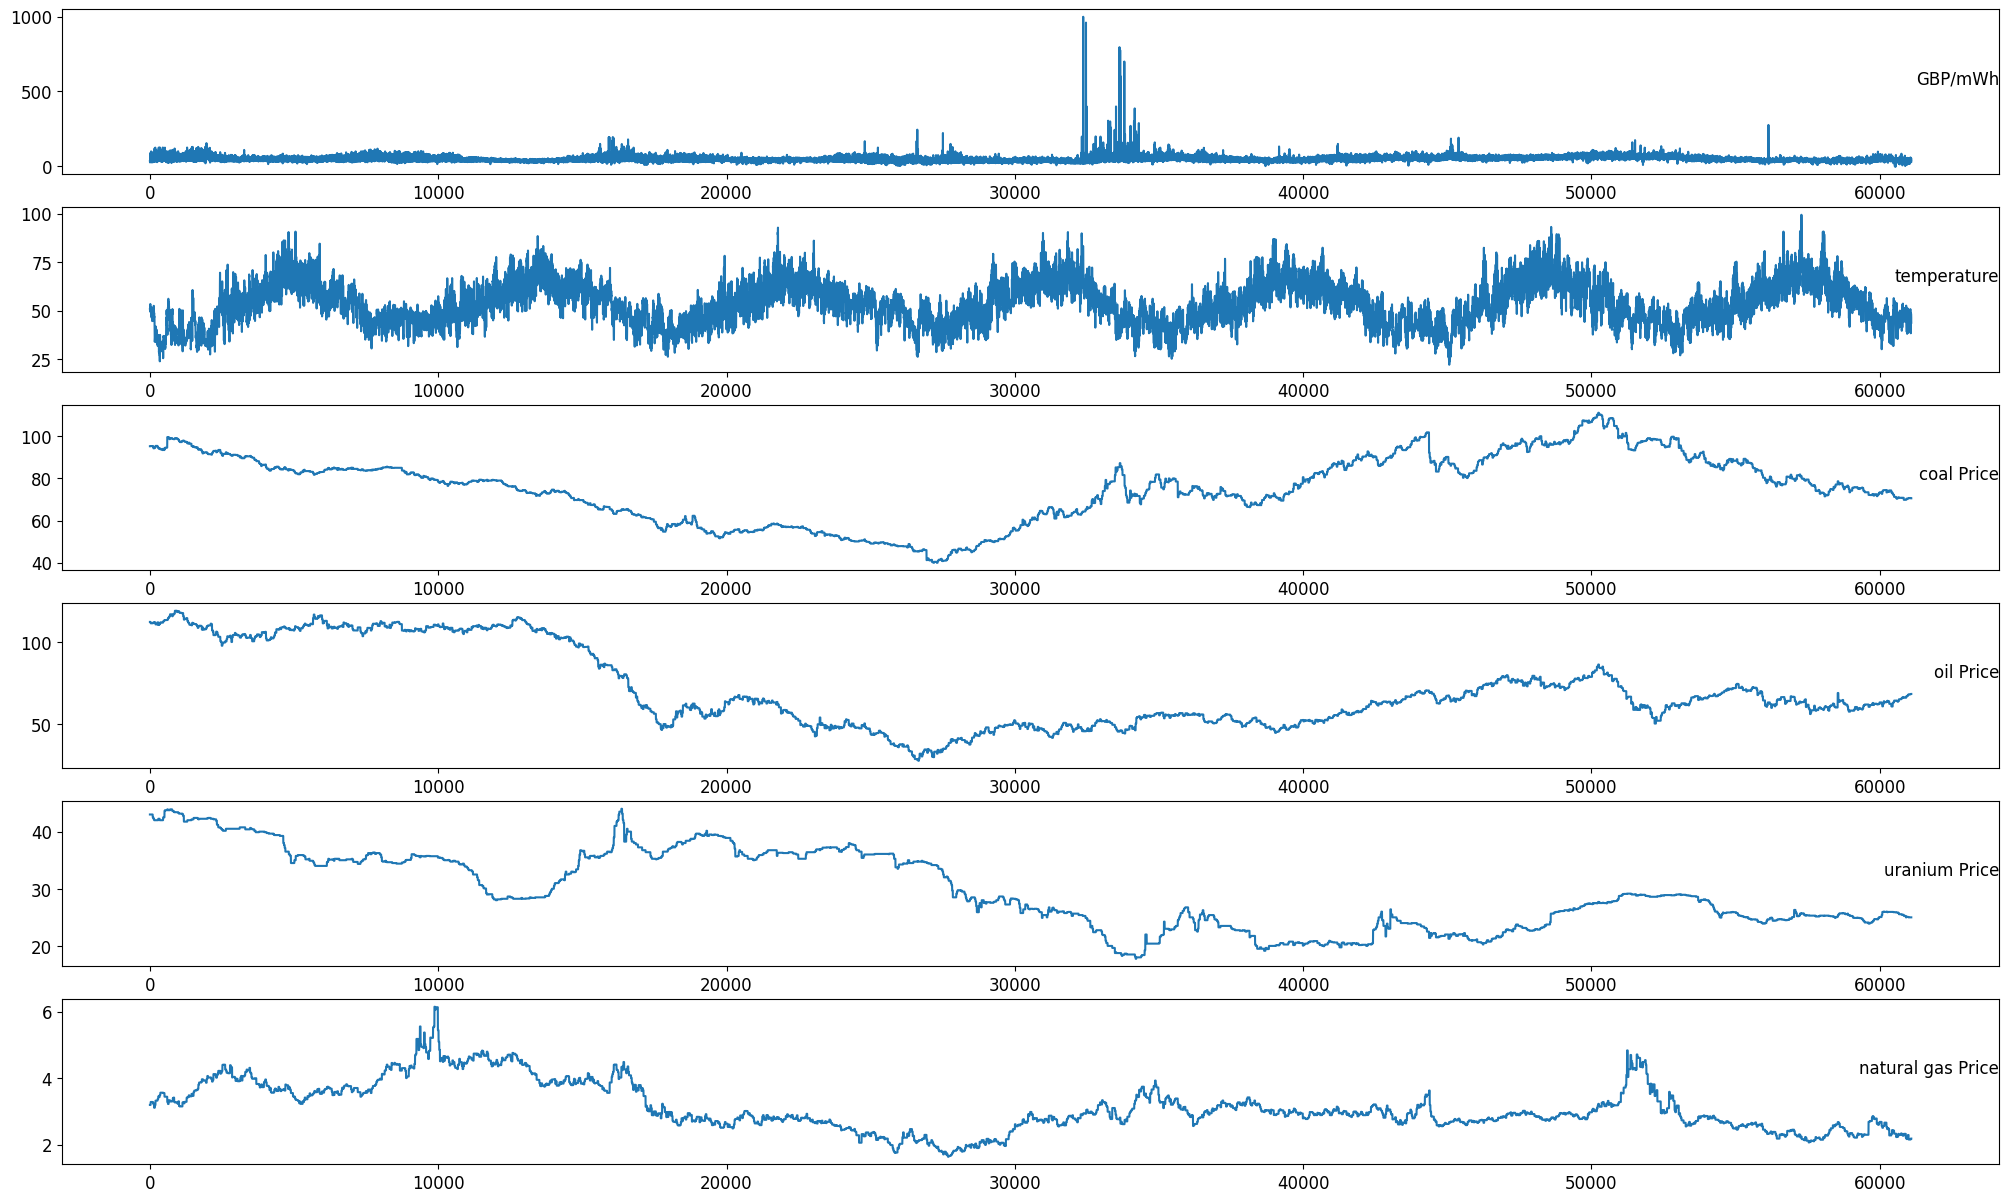

In [4]:
values = df.values

groups = [0, 1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [5]:
df.shape

(61097, 6)

In [6]:
n_steps = 168 #24*7
data = df.values

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

data = scaled_df.values

168+24 인 192 시간으로 데이터를 편집한 것은 168시간으로 학습 시킨 뒤 24 시간을 예측하게 만들기 위함이라 예상됨

In [77]:
series_reshaped =  np.array([data[i:i + (n_steps+24)].copy() for i in range(len(data) - (n_steps+24))])

In [78]:
series_reshaped.shape

(60905, 192, 6)

In [94]:
X_train = series_reshaped[:8760*2, :n_steps]
X_valid = series_reshaped[8760*2:series_reshaped.shape[0]-8760, :n_steps]
X_test = series_reshaped[series_reshaped.shape[0]-8760:, :n_steps]
Y = np.empty((series_reshaped.shape[0], n_steps, 24))

for step_ahead in range(1, 24 + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:8760*2]
Y_valid = Y[8760*2:series_reshaped.shape[0]-8760]
Y_test = Y[series_reshaped.shape[0]-8760:]
print(X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape)

(17520, 168, 6) (34625, 168, 6) (8760, 168, 6) (17520, 168, 24) (34625, 168, 24) (8760, 168, 24)


X_train.shape = (8760, 168,6) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 결과치를 (6) 6개의 요소에 대해 나타낸 것
Y_train.shape = (8760, 168,24) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 전력가격 결과를 (24) 24시간에 대해 나타낸 것

In [89]:
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

In [90]:
es = EarlyStopping(monitor = 'val_loss')

In [95]:
model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(50, return_sequences=True, input_shape=[None, 6]),
    keras.layers.SimpleRNN(50, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model6.compile(loss="mape", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=100,
                    validation_data=(X_valid, Y_valid))

Epoch 1/100
548/548 [==============================] - 29s 51ms/step - loss: 47.5618 - val_loss: 52.3943
Epoch 2/100
548/548 [==============================] - 28s 51ms/step - loss: 20.6730 - val_loss: 41.3637
Epoch 3/100
548/548 [==============================] - 28s 51ms/step - loss: 19.1587 - val_loss: 41.2609
Epoch 4/100
548/548 [==============================] - 29s 52ms/step - loss: 18.1410 - val_loss: 36.6802
Epoch 5/100
548/548 [==============================] - 29s 53ms/step - loss: 16.9275 - val_loss: 37.3691
Epoch 6/100
548/548 [==============================] - 29s 53ms/step - loss: 16.0953 - val_loss: 32.8562
Epoch 7/100
548/548 [==============================] - 28s 51ms/step - loss: 15.4250 - val_loss: 27.1248
Epoch 8/100
548/548 [==============================] - 28s 51ms/step - loss: 14.9403 - val_loss: 28.3549
Epoch 9/100
548/548 [==============================] - 28s 51ms/step - loss: 14.8872 - val_loss: 27.1068
Epoch 10/100
548/548 [==============================] -

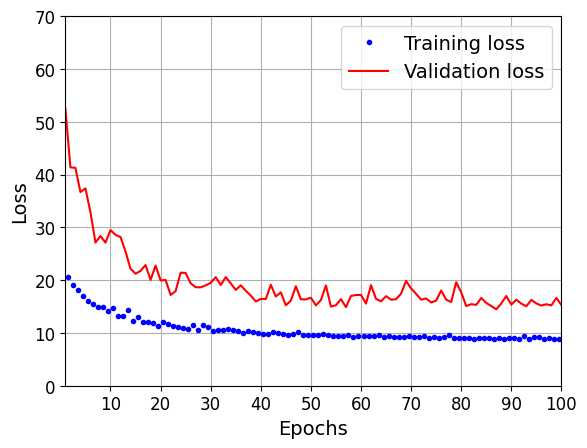

In [97]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 100, 0, 70])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

Multivariate Forecasting \n
(https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) \n
(https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

In [45]:
# prepare data for lstm
from pandas import DataFrame
from pandas import concat

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(data, 168, 24)
#drop columns we don't want to predict - 1번 column 만 예측할 거임
for t in range(0,24):
    for j in range(2,data.shape[1]+1):
        if t==0:
            reframed.drop(columns='var'+str(j)+'(t)',axis=1,inplace=True)
        else:
            reframed.drop(columns='var'+str(j)+'(t+'+str(t)+')',axis=1,inplace=True)

print(reframed.head())
reframed.shape

     var1(t-168)  var2(t-168)  var3(t-168)  var4(t-168)  var5(t-168)  \
168     0.036832     0.370256      0.77692     0.925731     0.961905   
169     0.033319     0.366899      0.77692     0.925731     0.961905   
170     0.031632     0.365737      0.77692     0.925731     0.961905   
171     0.030454     0.366254      0.77692     0.925731     0.961905   
172     0.029306     0.365866      0.77692     0.925731     0.961905   

     var6(t-168)  var1(t-167)  var2(t-167)  var3(t-167)  var4(t-167)  ...  \
168     0.345676     0.033319     0.366899      0.77692     0.925731  ...   
169     0.345676     0.031632     0.365737      0.77692     0.925731  ...   
170     0.345676     0.030454     0.366254      0.77692     0.925731  ...   
171     0.345676     0.029306     0.365866      0.77692     0.925731  ...   
172     0.345676     0.032340     0.363284      0.77692     0.925731  ...   

     var1(t+14)  var1(t+15)  var1(t+16)  var1(t+17)  var1(t+18)  var1(t+19)  \
168    0.054759    0.0510

(60906, 1032)

In [46]:
#1년치 Train data 지정 후 나머지 data 로 Test
values = reframed.values
n_feature = 1
futuretime = 24
pasttime = 168
n_train_hours = 8760
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]

#Split into input and outputs
train_X, train_y = train[:, :(-futuretime)*(n_feature)], train[:,(-futuretime)*(n_feature):]
test_X, test_y = test[:, :(-futuretime)*(n_feature)], test[:,(-futuretime)*(n_feature):]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 1008) (8760, 24) (52146, 1, 1008) (52146, 24)


LSTM

Epoch 1/100
274/274 - 6s - loss: 0.0133 - val_loss: 0.0364 - 6s/epoch - 21ms/step
Epoch 2/100
274/274 - 4s - loss: 0.0097 - val_loss: 0.0353 - 4s/epoch - 14ms/step
Epoch 3/100
274/274 - 3s - loss: 0.0092 - val_loss: 0.0340 - 3s/epoch - 13ms/step
Epoch 4/100
274/274 - 3s - loss: 0.0089 - val_loss: 0.0363 - 3s/epoch - 13ms/step
Epoch 5/100
274/274 - 4s - loss: 0.0088 - val_loss: 0.0363 - 4s/epoch - 13ms/step
Epoch 6/100
274/274 - 4s - loss: 0.0088 - val_loss: 0.0334 - 4s/epoch - 14ms/step
Epoch 7/100
274/274 - 4s - loss: 0.0088 - val_loss: 0.0383 - 4s/epoch - 13ms/step
Epoch 8/100
274/274 - 3s - loss: 0.0086 - val_loss: 0.0391 - 3s/epoch - 13ms/step
Epoch 9/100
274/274 - 3s - loss: 0.0086 - val_loss: 0.0367 - 3s/epoch - 13ms/step
Epoch 10/100
274/274 - 4s - loss: 0.0086 - val_loss: 0.0394 - 4s/epoch - 13ms/step
Epoch 11/100
274/274 - 3s - loss: 0.0085 - val_loss: 0.0430 - 3s/epoch - 13ms/step
Epoch 12/100
274/274 - 4s - loss: 0.0085 - val_loss: 0.0399 - 4s/epoch - 13ms/step
Epoch 13/100


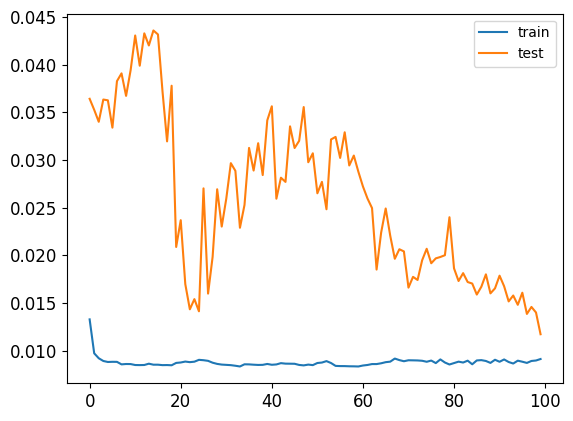

In [53]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_y.shape[1]))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Evalueate Model

In [76]:
print(test_X.shape)
y_test=model.predict(test_X)
test_X_re = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_yhat = concatenate((y_test, test_X_re[:, (-1)*(data.shape[1])+1:]), axis=1)
test_yhat.shape

(52146, 1, 1008)
1630/1630 [==============================] - 2s 2ms/step


(52146, 29)

In [64]:
from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X_re = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_re[:, (-1)*(data.shape[1])+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = scaler.inverse_transform(yhat[:,0:1])
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_re = test_y.reshape((test_y.shape[0], test_y.shape[1]))
#inv_y = concatenate((test_y_re, test_X_re[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = scaler.inverse_transform(test_y_re)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1630/1630 [==============================] - 2s 2ms/step


ValueError: Expected 2D array, got 1D array instead:
array=[0.03812294 0.03744832 0.03698124 ... 0.05439537 0.04923711 0.04502025].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
es = EarlyStopping(monitor = 'val_loss')

Deep Multivariate Recurrant Neural Network

In [ ]:
model6 = Sequential([
    SimpleRNN(100, return_sequences=True, input_shape=[None,6]),
    SimpleRNN(100, return_sequences=True),
    TimeDistributed(keras.layers.Dense(24))
])
print(model6.summary())

model6.compile(loss="mape", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_63 (SimpleRNN)   (None, None, 100)         10700     
                                                                 
 simple_rnn_64 (SimpleRNN)   (None, None, 100)         20100     
                                                                 
 time_distributed_34 (TimeDi  (None, None, 24)         2424      
 stributed)                                                      
                                                                 
Total params: 33,224
Trainable params: 33,224
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
  49/1356 [>.............................] - ETA: 2:00 - loss: 188.5354

KeyboardInterrupt: 

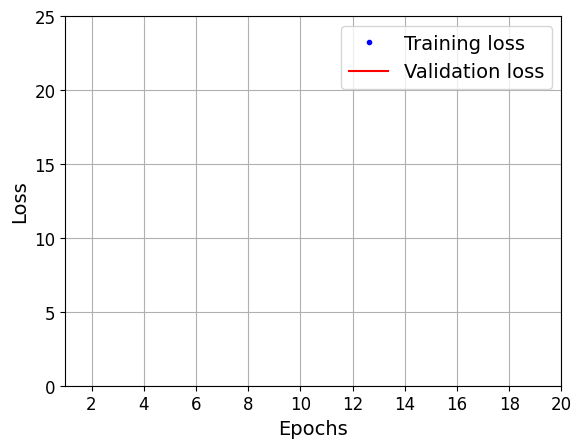

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 25])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

In [ ]:
# from google.colab import files
# actual.to_csv('RNNresults.csv') 
# files.download('RNNresults.csv')

KeyboardInterrupt: ignored

Simple Long-Short Term Memory Model

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model8 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 6]),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model8.compile(loss="mape", optimizer="adam")
history = model8.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 43800 samples, validate on 8760 samples
Epoch 1/20
43800/43800 [==============================] - 17s 396us/sample - loss: 23.7422 - val_loss: 17.8767
Epoch 2/20
43800/43800 [==============================] - 12s 278us/sample - loss: 15.8340 - val_loss: 17.6940
Epoch 3/20
43800/43800 [==============================] - 12s 278us/sample - loss: 14.5503 - val_loss: 14.5041
Epoch 4/20
43800/43800 [==============================] - 12s 275us/sample - loss: 13.6600 - val_loss: 12.8433
Epoch 5/20
43800/43800 [==============================] - 12s 282us/sample - loss: 12.7653 - val_loss: 12.5096
Epoch 6/20
43800/43800 [==============================] - 12s 280us/sample - loss: 12.5216 - val_loss: 12.3429
Epoch 7/20
43800/43800 [==============================] - 12s 278us/sample - loss: 12.3605 - val_loss: 12.1632
Epoch 8/20
43800/43800 [==============================] - 12s 277us/sample - loss: 12.0969 - val_loss: 12.1775
Epoch 9/20
43800/43800 [==============================] - 12s 2

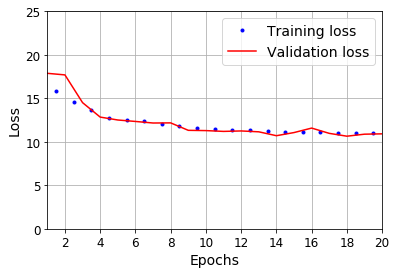

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('simplelstmresults.csv') 
# files.download('simplelstmresults.csv')

Deep LSTM model

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model9 = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences= True, input_shape=(168,6)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(40, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(30, return_sequences= True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model9.compile(loss="mape", optimizer="adam")
history9 = model9.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks = [es] )

Train on 43800 samples, validate on 8760 samples
Epoch 1/20
43800/43800 [==============================] - 33s 756us/sample - loss: 16.5568 - val_loss: 14.9663
Epoch 2/20
43800/43800 [==============================] - 30s 693us/sample - loss: 12.6913 - val_loss: 11.9877
Epoch 3/20
43800/43800 [==============================] - 30s 693us/sample - loss: 11.6552 - val_loss: 10.9733
Epoch 4/20
43800/43800 [==============================] - 30s 692us/sample - loss: 11.1535 - val_loss: 11.0863


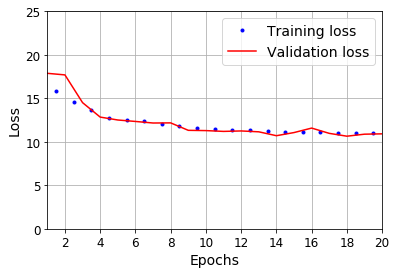

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('deeplstmresults.csv') 
# files.download('deeplstmresults.csv')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 6]),
    keras.layers.GRU(60, return_sequences=True),
    keras.layers.GRU(40, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model10.compile(loss="mape", optimizer="adam")
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es])

Train on 43800 samples, validate on 8760 samples
Epoch 1/20
43800/43800 [==============================] - 16s 357us/sample - loss: 17.2059 - val_loss: 14.7603
Epoch 2/20
43800/43800 [==============================] - 13s 306us/sample - loss: 12.4322 - val_loss: 10.9715
Epoch 3/20
43800/43800 [==============================] - 13s 304us/sample - loss: 11.3294 - val_loss: 11.1987


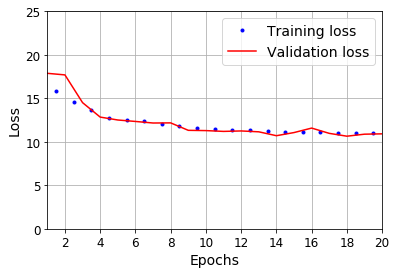

In [ ]:

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
Y_pred = model10.predict(X_test)


In [ ]:
Y_pred.shape

In [ ]:
Y_pred = model10.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][3::2][0][23]))
    

actual = pd.DataFrame(X_test[: , 0, 0])
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('convlayerresults.csv') 
# files.download('convlayerresults.csv')